# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision.transforms.v2 as transforms
from IPython.display import clear_output
from skimage.io import imread, imsave
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

import transforms3d as T
from dataset3d import BNSet, BNSetMasks, get_dloader_mask
from model3d import CNN3d
from util3d import get_obj_score3d, get_saliency3d, show_volume

sns.set_theme()

In [3]:
data_dir = "../data/bugNIST_DATA"

name_legend = {
    "ac": "brown_cricket",
    "bc": "black_cricket",
    "bf": "blow_fly",
    "bl": "buffalo_bettle_larva",
    "bp": "blow_fly_pupa",
    "cf": "curly-wing_fly",
    "gh": "grasshopper",
    "ma": "maggot",
    "ml": "mealworm",
    "pp": "green_bottle_fly_pupa",
    "sl": "soldier_fly_larva",
    "wo": "woodlice",
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# Training loop

In [4]:
lr = 1e-4

batch_size = 16
num_workers = 8

subset = ["ac", "bc"]

trainloader = get_dloader_mask(
    "train",
    batch_size,
    data_dir=data_dir,
    subset=subset,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
)
valloader = get_dloader_mask(
    "val",
    batch_size,
    data_dir=data_dir,
    subset=subset,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
)

model = CNN3d(len(subset))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [5]:
stats = {}
for epoch in range(50):
    metrics_train = {
        "loss": [],
        "preds": [],
        "labels": [],
    }
    metrics_val = {
        "loss": [],
        "preds": [],
        "labels": [],
    }

    print(f"Epoch {epoch}")
    model.train()
    for volumes, labels, masks in tqdm(trainloader):
        out = model((volumes * masks).to(device))

        loss = criterion(out, labels.type(torch.LongTensor).to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _, indices = torch.max(out.cpu(), 1)

        metrics_train["loss"].append(loss.cpu().detach().item())
        metrics_train["preds"].append(indices.detach().numpy())
        metrics_train["labels"].append(labels.numpy())

    model.eval()
    for volumes, labels, masks in tqdm(valloader):
        out = model((volumes * masks).to(device))

        with torch.no_grad():
            loss = criterion(out, labels.type(torch.LongTensor).to(device))

        _, indices = torch.max(out.cpu(), 1)

        metrics_val["loss"].append(loss.cpu().detach().item())
        metrics_val["preds"].append(indices.detach().numpy())
        metrics_val["labels"].append(labels.numpy())

    performance = {
        "train_loss": np.mean(metrics_train["loss"]),
        "train_accuracy": np.mean(
            np.concatenate(metrics_train["preds"])
            == np.concatenate(metrics_train["labels"])
        ).item(),
        "val_loss": np.mean(metrics_val["loss"]),
        "val_accuracy": np.mean(
            np.concatenate(metrics_val["preds"])
            == np.concatenate(metrics_val["labels"])
        ).item(),
    }
    print(performance)
    stats[epoch] = performance

Epoch 0


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

{'train_loss': 0.6790984102657863, 'train_accuracy': 0.6031390134529148, 'val_loss': 0.6512778918994101, 'val_accuracy': 0.6326530612244898}
Epoch 1


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

{'train_loss': 0.6451953261026314, 'train_accuracy': 0.6412556053811659, 'val_loss': 0.6512011587619781, 'val_accuracy': 0.6496598639455783}
Epoch 2


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

{'train_loss': 0.6249055058828422, 'train_accuracy': 0.6569506726457399, 'val_loss': 0.6434533894062042, 'val_accuracy': 0.6530612244897959}
Epoch 3


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

{'train_loss': 0.6168746096747262, 'train_accuracy': 0.679372197309417, 'val_loss': 0.6635884124981729, 'val_accuracy': 0.5884353741496599}
Epoch 4


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

{'train_loss': 0.614099560039384, 'train_accuracy': 0.6748878923766816, 'val_loss': 0.6500791499489232, 'val_accuracy': 0.5952380952380952}
Epoch 5


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

{'train_loss': 0.6137905583849975, 'train_accuracy': 0.6659192825112108, 'val_loss': 0.6414079932790053, 'val_accuracy': 0.6360544217687075}
Epoch 6


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

{'train_loss': 0.6079297502126012, 'train_accuracy': 0.6704035874439462, 'val_loss': 0.6404446190909335, 'val_accuracy': 0.6530612244897959}
Epoch 7


  0%|          | 0/56 [00:00<?, ?it/s]

KeyboardInterrupt: 

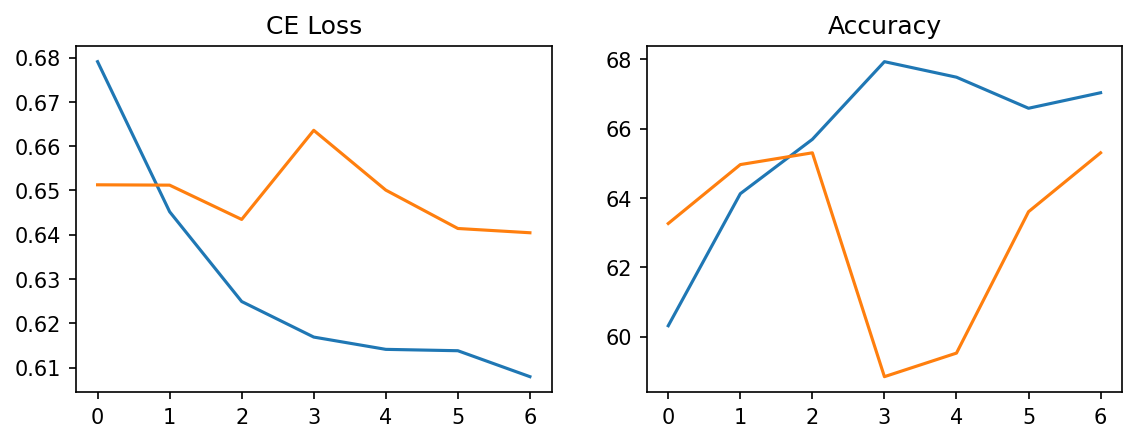

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 3), dpi=150)

ax0.plot(stats.keys(), [stats[epoch]["train_loss"] for epoch in stats])
ax0.plot(stats.keys(), [stats[epoch]["val_loss"] for epoch in stats])
ax0.set_title("CE Loss")

ax1.plot(stats.keys(), [stats[epoch]["train_accuracy"] * 100 for epoch in stats])
ax1.plot(stats.keys(), [stats[epoch]["val_accuracy"] * 100 for epoch in stats])
ax1.set_title("Accuracy")
plt.show()

# Saliency

In [19]:
dloader = get_dloader_mask("val", 1, data_dir=data_dir, subset=subset, num_workers=0)
model.eval();

In [20]:
dloader_iter = iter(dloader)

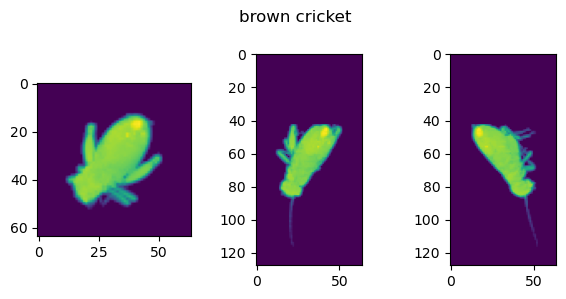

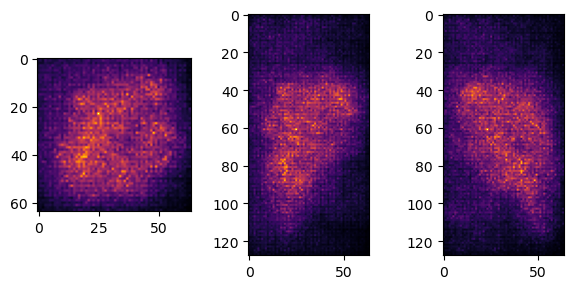

(0.6955660223236917, 0, 0)

In [34]:
volumes, labels, masks = next(dloader_iter)
volumes = volumes * masks

slc, score, indices, out = get_saliency3d(model, volumes, device=device)
obj_score = get_obj_score3d(slc, masks)

slc_abs = np.abs(slc)

show_volume(volumes.detach().numpy(), labels.item())
show_volume(slc_abs / slc_abs.max(), cmap="inferno")
obj_score, indices.item(), labels.item()

In [10]:
obj_scores = []
for volumes, labels, masks in tqdm(dloader):
    volumes *= masks

    slc, score, indices, out = get_saliency3d(model, volumes, device=device)
    obj_score = get_obj_score3d(slc, masks)

    obj_scores.append(obj_score)

np.mean(obj_scores)

  0%|          | 0/294 [00:00<?, ?it/s]

0.7358898698829546